<a href="https://colab.research.google.com/github/Shiyi-Xia/NLP_ESS_2022/blob/main/Tutorial_Nine_(R)_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Convolutional Neural Networks

## Douglas Rice

In this notebook, we'll introduce Convolutional Neural Network architecture. As before, building the models in Keras requires relatively straightforward modifications from our prior work. 

#### Setup Instructions:
This notebook was designed to run in a clean R runtime within Google Colab. Before running any of the code below, go up to the menu at the top of the window and click "runtime," then, from the dropdown, click "Disconnect and Delete Runtime". Then, reconnect. That should get everything set up to run smoothly. 


## Setup

In [ ]:
install.packages("keras") # install R library for keras; this installs dependencies we'll need, including tensorflow

library(tensorflow) # load R library for tensorflow
library(keras) # load R library for keras

tf$constant("Hello Tensorflow") # check that tensorflow is working

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Loaded Tensorflow version 2.8.2



tf.Tensor(b'Hello Tensorflow', shape=(), dtype=string)

We now need to add a new package, `tfhub`. This is the Tensorflow Hub, which is a repository of reusable machine learning models. `tfhub` is an R package that provides access to all of the models retained on Tensorflow Hub. 

In [ ]:
install.packages("tfdatasets")
library(tfdatasets)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Load the IMDB data


In [ ]:
url <- "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset <- get_file(
  "aclImdb_v1",
  url,
  untar = TRUE,
  cache_dir = '.',
  cache_subdir = ''
)

In [ ]:
dataset_dir <- file.path("aclImdb")
list.files(dataset_dir)


[1] "imdb.vocab" "imdbEr.txt" "README"     "test"       "train"

In [ ]:
train_dir <- file.path(dataset_dir, 'train')
list.files(train_dir)

[1] "labeledBow.feat" "neg"             "pos"             "unsup"          
[5] "unsupBow.feat"   "urls_neg.txt"    "urls_pos.txt"    "urls_unsup.txt"

In [ ]:
sample_file <- file.path(train_dir, 'pos/1181_9.txt')
readr::read_file(sample_file)

[1] "Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived."

In [ ]:
remove_dir <- file.path(train_dir, 'unsup')
unlink(remove_dir, recursive = TRUE)

In [ ]:
batch_size <- 512
seed <- 42

raw_train_ds <- text_dataset_from_directory(
  'aclImdb/train',
  batch_size = batch_size,
  validation_split = 0.2,
  subset = 'training',
  seed = seed
)

In [ ]:
raw_val_ds <- text_dataset_from_directory(
  'aclImdb/train',
  batch_size = batch_size,
  validation_split = 0.2,
  subset = 'validation',
  seed = seed
)

raw_test_ds <- text_dataset_from_directory(
  'aclImdb/test',
  batch_size = batch_size
)

## Apply TextVectorization

You can send a different tokenizer to the TextVectorization layer -- and the reviews do have some detritus like html tags that probably should be removed -- but we'll just use the default.

Now let's set up our vectorize_layer for real. We'll set our maximum vocabulary and our maximum review length.

In [ ]:
max_features <- 5000
sequence_length <- 500

vectorize_layer <- layer_text_vectorization(
  max_tokens = max_features,
  output_mode = "int",
  output_sequence_length = sequence_length
)

We'll call the adapt function to build the vocabulary from the text of the reviews.



In [ ]:
train_text <- raw_train_ds %>%
  dataset_map(function(text, label) text)
  
vectorize_layer %>% adapt(train_text)

In [ ]:
vectorize_text <- function(text, label) {
  text <- tf$expand_dims(text, -1L)
  list(vectorize_layer(text), label)
}

In [ ]:
train_ds <- raw_train_ds %>% dataset_map(vectorize_text)
val_ds <- raw_val_ds %>% dataset_map(vectorize_text)
test_ds <- raw_test_ds %>% dataset_map(vectorize_text)

## Performance Considerations

In [ ]:
AUTOTUNE <- tf$data$AUTOTUNE

train_ds <- train_ds %>%
  dataset_cache() %>%
  dataset_prefetch(buffer_size = AUTOTUNE)
val_ds <- val_ds %>%
  dataset_cache() %>%
  dataset_prefetch(buffer_size = AUTOTUNE)
test_ds <- test_ds %>%
  dataset_cache() %>%
  dataset_prefetch(buffer_size = AUTOTUNE)

# Create the Model

Now we'll build a basic CNN. To do so, we incorporate two new types of layers in our Sequential model. The first is a 1D convolution layer (`Conv1D` in the below). This layer creates a convolution kernel that is convolved with the layer input over a single temporal dimension. The second is a pooling layer (`GlobalMaxPooling1D`) that downsamples the input representation by taking the maximum value over the time dimension.

In [ ]:
embedding_dim <- 16



In [ ]:
model <- keras_model_sequential() %>%
  layer_embedding(max_features + 1, embedding_dim) %>%
  layer_conv_1d(128, 3, activation = "relu") %>%
  layer_global_max_pooling_1d() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 1, activation = "sigmoid")

summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding (Embedding)              (None, None, 16)                80016       
 conv1d (Conv1D)                    (None, None, 128)               6272        
 global_max_pooling1d (GlobalMaxPoo  (None, 128)                    0           
 ling1D)                                                                        
 dense_1 (Dense)                    (None, 16)                      2064        
 dropout (Dropout)                  (None, 16)                      0           
 dense (Dense)                      (None, 1)                       17          
Total params: 88,369
Trainable params: 88,369
Non-trainable params: 0
________________________________________________________________________________


In [ ]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

Note this next model fitting stage takes 
about 7 minutes to complete.

In [ ]:
history <- model %>% fit(
  train_ds,
  epochs = 10,
  validation_data = val_ds,
  verbose = 2
)

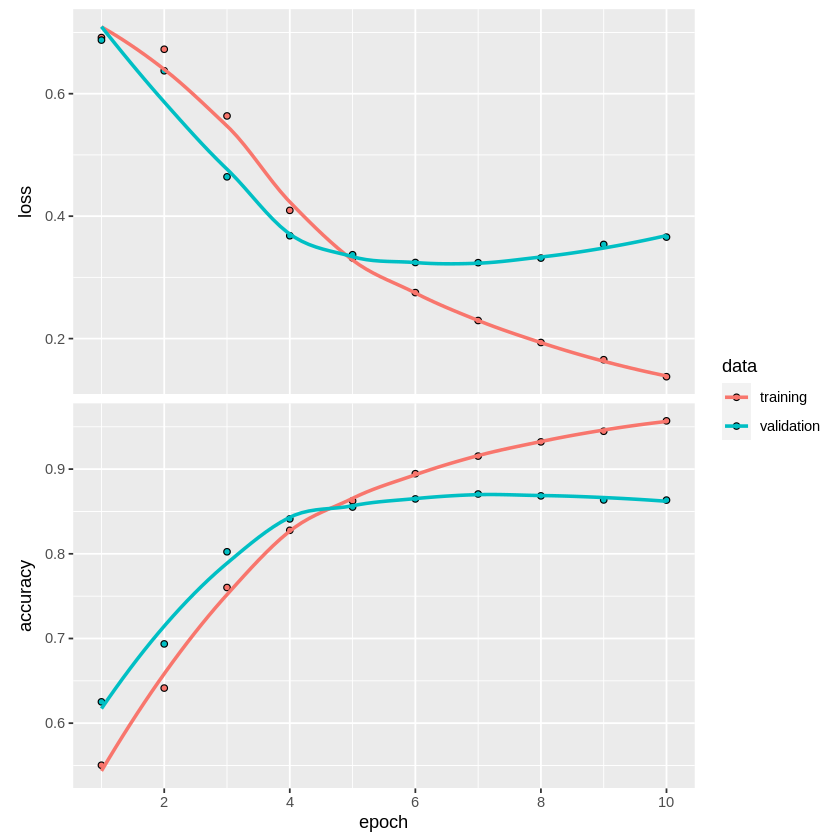

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(test_ds, verbose = 2)

In [ ]:
results

loss  accuracy 
0.3508497 0.8658800

We're at about 87%. Some progress! 

# Build a Deep CNN

Let's try a more complex setup, and build a deeper CNN with multiple convolution layers and multiple pooling layers. 

In [ ]:
model <- keras_model_sequential() %>%
  layer_embedding(max_features + 1, embedding_dim) %>%
  layer_conv_1d(256, 3, activation = "relu", padding = "same") %>%
  layer_max_pooling_1d() %>%
  layer_conv_1d(128, 3, activation = "relu") %>%
  layer_global_max_pooling_1d() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 1, activation = "sigmoid")

summary(model)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding_1 (Embedding)            (None, None, 16)                80016       
 conv1d_2 (Conv1D)                  (None, None, 256)               12544       
 max_pooling1d (MaxPooling1D)       (None, None, 256)               0           
 conv1d_1 (Conv1D)                  (None, None, 128)               98432       
 global_max_pooling1d_1 (GlobalMaxP  (None, 128)                    0           
 ooling1D)                                                                      
 dense_3 (Dense)                    (None, 16)                      2064        
 dropout_1 (Dropout)                (None, 16)                      0           
 dense_2 (Dense)                    (None, 1)                       17          
Total params: 193,073
Trainable params: 193,073
Non-trainable params: 0
_______________

In [ ]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

In [ ]:
history <- model %>% fit(
  train_ds,
  epochs = 10,
  validation_data = val_ds,
  verbose = 2
)

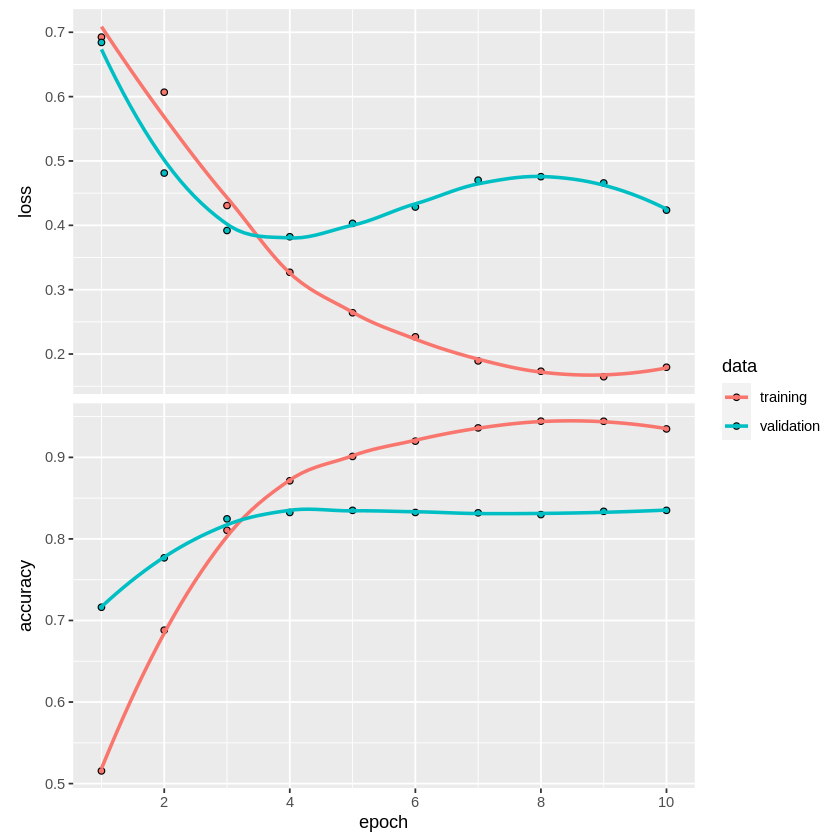

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(test_ds, verbose = 2)

In [ ]:
results

loss  accuracy 
0.4094347 0.8360000

84%. Going in the wrong direction!